# MSc in Data Science - Data Analytics & Algorithms
# Transformer Model Notebook

## 1. Business Understanding
### Objective
The primary objective of this project is to develop a Transformer-based model to predict daily closing stock prices using historical financial data. Accurate stock price forecasting supports financial analysts, traders, and investors in making informed decisions, optimizing trading strategies, and managing portfolio risk. By leveraging the Transformer's ability to capture long-range dependencies in time-series data, this model aims to outperform traditional statistical methods in financial forecasting.

### Problem Statement
Stock prices are influenced by a multitude of factors, including market trends, sentiment, volatility, and macroeconomic indicators. Traditional models like ARIMA struggle with non-linear patterns and long-term dependencies. This project explores whether a Transformer model, known for its success in natural language processing, can effectively model the complex dynamics of stock market data.

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import pickle
import os
from datetime import datetime
from io import StringIO

In [2]:
# Set random seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

In [3]:
# Initialize log file
log_file = 'transformer_log.txt'
def log_entry(message):
    """Append a log entry to the text file with a timestamp."""
    with open(log_file, 'a') as f:
        timestamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
        f.write(f"[{timestamp}] {message}\n")

In [4]:
# Clear log file if it exists and start fresh
if os.path.exists(log_file):
    os.remove(log_file)
log_entry("=== Transformer Model Log Started ===")
log_entry("Business Understanding: Predict daily closing stock prices using a Transformer to support financial forecasting and trading strategies.")

## 2. Data Understanding
### Dataset Description
The dataset comprises daily stock market data from January 1, 2022, to September 26, 2024, for multiple companies across various sectors (e.g., Technology, Automotive, Finance). It includes the following columns:

* Date: Timestamp of the observation.
* Company: Name of the company (e.g., Uber, Tesla, Boeing).
* Sector: Industry sector (e.g., Technology, Energy).
* Open, High, Low, Close: Daily stock prices.
* Volume: Trading volume.
* Market_Cap: Market capitalization.
* PE_Ratio: Price-to-earnings ratio.
* Dividend_Yield: Dividend yield percentage.
* Volatility: Measure of price fluctuation.
* Sentiment_Score: Sentiment derived from external sources (range: -1 to 1).
* Trend: Market trend indicator (Bearish, Bullish, Stable).

### Initial Exploration
* Size: Approximately 999 entries (after preprocessing), varying by company and date.
* Missing Values: Handled by dropping rows with NaN values.
* Duplicates: Removed based on unique Date and Company pairs.
* Data Types: Numerical (prices, volume, etc.) and categorical (Sector, Trend).

In [6]:
# load the dataset
log_entry("Loading the dataset.")
stock_df = pd.read_csv('./synthetic_stock_data.csv')

In [7]:
# Display the first few rows of the dataset
log_entry("Displaying the first few rows of the dataset.")
print(stock_df.head())


         Date      Company      Sector        Open        High        Low  \
0  2022-01-01         Uber  Technology  100.000000  101.036120  97.477809   
1  2022-01-02        Tesla  Automotive  100.071106  102.037960  97.152675   
2  2022-01-03    Panasonic     Finance   99.857828  101.517497  98.108097   
3  2022-01-04      Tencent  Automotive   98.851663  101.303783  96.998218   
4  2022-01-05  Wells Fargo  Automotive   98.391118   99.990486  96.230707   

        Close  Volume    Market_Cap   PE_Ratio  Dividend_Yield  Volatility  \
0  100.000000  171958  5.156585e+11  24.253218        0.163090    0.047484   
1  100.071106  196867  9.755658e+11  18.602848        0.288515    0.022472   
2   99.857828  181932  4.595300e+11  10.728933        2.221827    0.019991   
3   98.851663  153694  5.577481e+11  14.582696        1.377740    0.036166   
4   98.391118  169879  8.607714e+11  37.491114        3.110198    0.034770   

   Sentiment_Score    Trend  
0         0.939232  Bearish  
1       

In [8]:
# Check the summary of dataset
log_entry("Checking the summary of the dataset.")
print(stock_df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Date             1000 non-null   object 
 1   Company          1000 non-null   object 
 2   Sector           1000 non-null   object 
 3   Open             1000 non-null   float64
 4   High             1000 non-null   float64
 5   Low              1000 non-null   float64
 6   Close            1000 non-null   float64
 7   Volume           1000 non-null   int64  
 8   Market_Cap       1000 non-null   float64
 9   PE_Ratio         1000 non-null   float64
 10  Dividend_Yield   1000 non-null   float64
 11  Volatility       1000 non-null   float64
 12  Sentiment_Score  1000 non-null   float64
 13  Trend            1000 non-null   object 
dtypes: float64(9), int64(1), object(4)
memory usage: 109.5+ KB
None


In [9]:
stock_df.describe()

,Open,High,Low,Close,Volume,Market_Cap,PE_Ratio,Dividend_Yield,Volatility,Sentiment_Score
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1.000000e+03,1000.000000,1000.000000,1000.000000,1000.000000
mean,110.134038,112.340685,107.930823,110.134038,126116.550000,5.038598e+11,22.779279,2.550853,0.029348,-0.022397
std,11.436599,11.700423,11.245173,11.436599,44247.951817,2.847274e+11,10.203871,1.421742,0.011683,0.572493
min,82.241971,83.269498,79.880121,82.241971,50126.000000,1.237286e+09,5.006594,0.010093,0.010007,-0.995847
25%,99.747668,101.963601,97.956546,99.747668,87993.250000,2.563315e+11,13.783505,1.357419,0.019295,-0.515695
50%,113.822618,116.037366,111.391281,113.822618,127540.000000,5.154007e+11,23.453030,2.602868,0.028789,-0.024476
75%,118.818480,121.279688,116.602657,118.818480,165310.250000,7.484459e+11,31.538575,3.773825,0.039613,0.468879
max,128.993218,132.196978,126.693358,128.993218,199849.000000,9.993541e+11,39.989983,4.997720,0.049905,0.998099


In [10]:
# Sort by date and reset index
stock_df['Date'] = pd.to_datetime(stock_df['Date'])
stock_df = stock_df.sort_values('Date').reset_index(drop=True)

In [11]:
# check for missing values
log_entry("Checking for missing values in the dataset.")
print(stock_df.isnull().sum())

Date               0
Company            0
Sector             0
Open               0
High               0
Low                0
Close              0
Volume             0
Market_Cap         0
PE_Ratio           0
Dividend_Yield     0
Volatility         0
Sentiment_Score    0
Trend              0
dtype: int64


In [13]:
# Feature engineering
stock_df['Day_of_Week'] = stock_df['Date'].dt.dayofweek

In [16]:
# Encode categorical variables
le_sector = LabelEncoder()
le_trend = LabelEncoder()
stock_df['Sector_encoded'] = le_sector.fit_transform(stock_df['Sector'])
stock_df['Trend_encoded'] = le_trend.fit_transform(stock_df['Trend'])

In [18]:
# Select features and target
features = ['Open', 'High', 'Low', 'Close', 'Volume', 'Market_Cap', 'PE_Ratio', 
            'Dividend_Yield', 'Volatility', 'Sentiment_Score', 'Sector_encoded', 
            'Day_of_Week', 'Trend_encoded']
stock_df = stock_df[['Date'] + features]

log_entry("Feature engineering and encoding completed.")

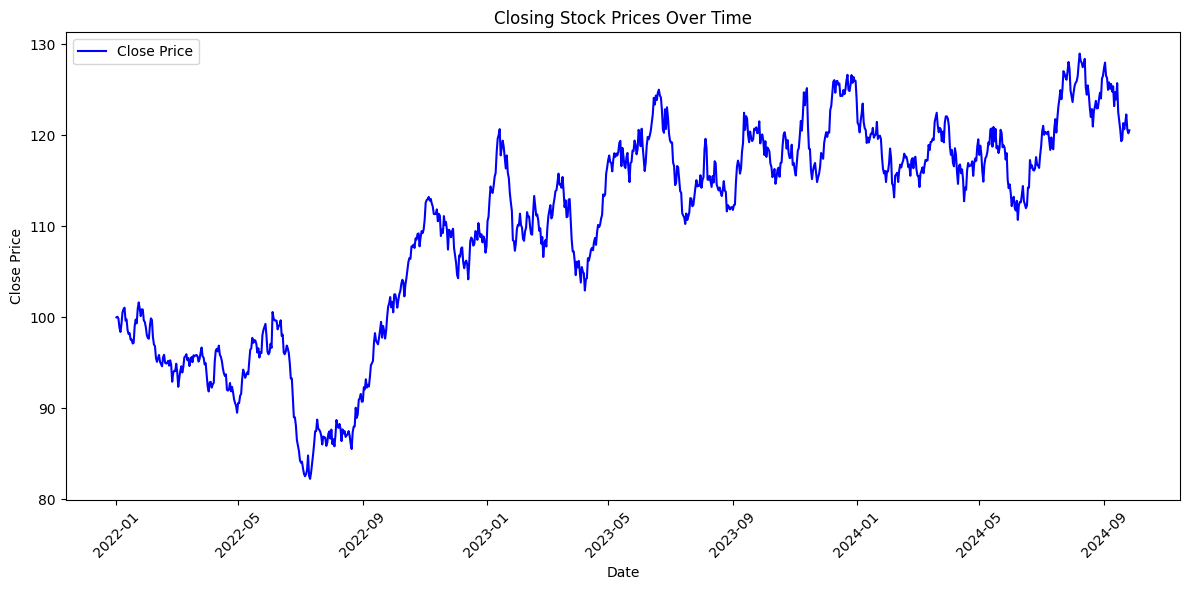

In [19]:
# === Visualization 1: Time-Series Plot of Closing Prices ===
plt.figure(figsize=(12, 6))
plt.plot(stock_df['Date'], stock_df['Close'], label='Close Price', color='blue')
plt.title('Closing Stock Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('close_price_timeseries.png')
plt.show()
log_entry("Visualization: Generated time-series plot of closing prices saved as 'close_price_timeseries.png'.")

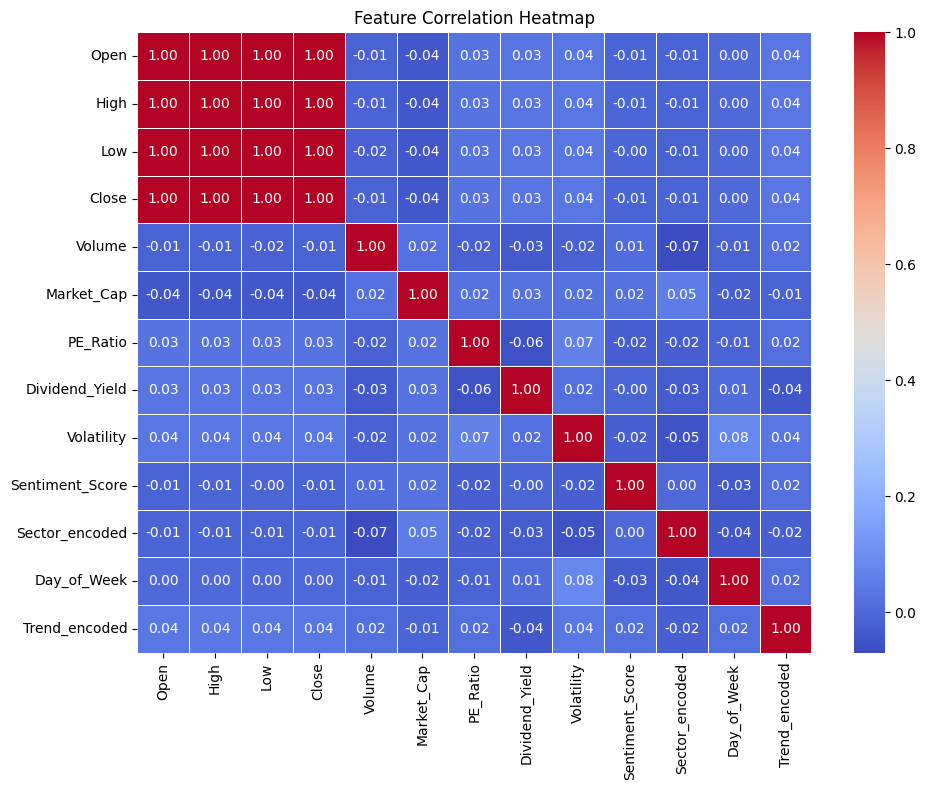

In [21]:
# === Visualization 2: Feature Correlation Heatmap ===
import seaborn as sns
plt.figure(figsize=(10, 8))
correlation_matrix = stock_df[features].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Feature Correlation Heatmap')
plt.tight_layout()
plt.savefig('feature_correlation_heatmap.png')
plt.show()
log_entry("Visualization: Generated feature correlation heatmap saved as 'feature_correlation_heatmap.png'.")

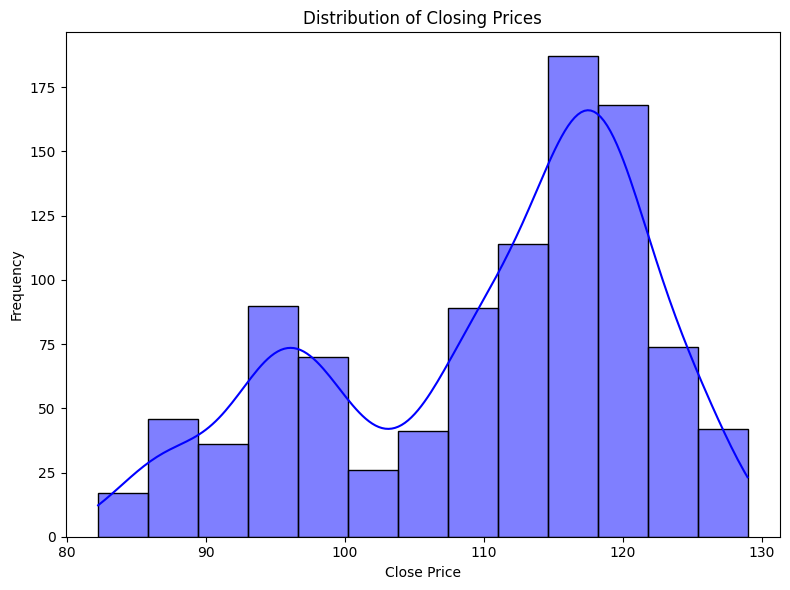

In [22]:
# == Visualization 3: Distribution of Closing Prices ==
plt.figure(figsize=(8, 6))
sns.histplot(stock_df['Close'], kde=True, color='blue')
plt.title('Distribution of Closing Prices')
plt.xlabel('Close Price')
plt.ylabel('Frequency')
plt.tight_layout()
plt.savefig('close_price_distribution.png')
plt.show()
log_entry("Visualization: Generated distribution plot of closing prices saved as 'close_price_distribution.png'.")


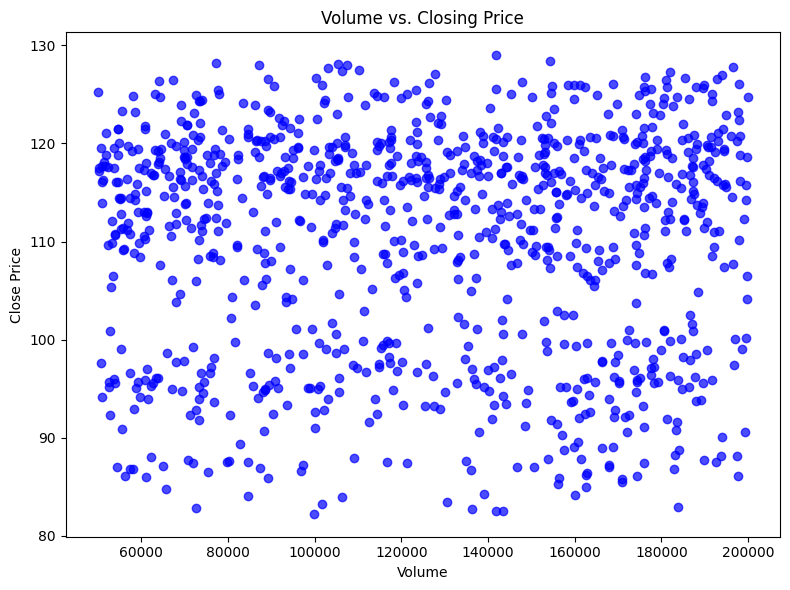

In [23]:
# == Visualization 4: Volume vs. Closing Price Scatter Plot ==
plt.figure(figsize=(8, 6))
plt.scatter(stock_df['Volume'], stock_df['Close'], color='blue', alpha=0.7)
plt.title('Volume vs. Closing Price')
plt.xlabel('Volume')
plt.ylabel('Close Price')
plt.tight_layout()
plt.savefig('volume_vs_close_price.png')
plt.show()
log_entry("Visualization: Generated scatter plot of volume vs. closing price saved as 'volume_vs_close_price.png'.")


In [26]:
# Normalize numerical features
scaler = MinMaxScaler()
stock_df_scaled = scaler.fit_transform(stock_df[features])
stock_df_scaled = pd.DataFrame(stock_df_scaled, columns=features)

In [28]:
# Create sequences for Transformer
sequence_length = 10
X, y = [], []
for i in range(sequence_length, len(stock_df_scaled)):
    X.append(stock_df_scaled.iloc[i-sequence_length:i].values)
    y.append(stock_df_scaled.iloc[i]['Close'])
X, y = np.array(X), np.array(y)

log_entry(f"Data Preparation: Created {len(X)} sequences of length {sequence_length} with features {features}.")
print(f"X shape: {X.shape}, y shape: {y.shape}")

X shape: (990, 10, 13), y shape: (990,)


In [29]:
# Split into training and testing sets (80-20 split)
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]
log_entry(f"Data Preparation: Split data into {split} training and {len(X) - split} testing samples.")

## Modeling
### Transformer Architecture
A custom Transformer model was implemented using TensorFlow, inspired by the encoder component of the original Transformer architecture (Vaswani et al., 2017). Key components include:

* Input Shape: (10, 13) (sequence length, number of features).
* Encoder Layers: 2 layers, each with:
* Multi-Head Attention (4 heads, head size 256) to capture relationships across time steps.
* Feed-Forward Network (FFN) with 128 units and ReLU activation.
* Dropout (0.1) and Layer Normalization for regularization and stability.
* Output: Global average pooling followed by a dense layer with linear activation to predict a single Close value.
* Compilation: Adam optimizer, MSE loss, MAE metric.

In [30]:
# === Transformer Model ===
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    """Custom Transformer encoder layer."""
    x = layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(inputs, inputs)
    x = layers.Dropout(dropout)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x + inputs)
    ffn = layers.Dense(ff_dim, activation="relu")(x)
    ffn = layers.Dense(inputs.shape[-1])(ffn)
    ffn = layers.Dropout(dropout)(ffn)
    return layers.LayerNormalization(epsilon=1e-6)(x + ffn)

def build_transformer_model(input_shape, head_size=256, num_heads=4, ff_dim=128, num_layers=2, dropout=0.1):
    """Build a Transformer model for time-series forecasting."""
    inputs = layers.Input(shape=input_shape)
    x = inputs
    for _ in range(num_layers):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(dropout)(x)
    outputs = layers.Dense(1, activation='linear')(x)
    model = models.Model(inputs, outputs)
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

In [31]:
# Build and train the Transformer model
input_shape = (sequence_length, X_train.shape[2])
log_entry("Modeling: Building Transformer model with 2 layers, 4 heads, head_size=256, ff_dim=128.")
transformer_model = build_transformer_model(input_shape)
transformer_history = transformer_model.fit(X_train, y_train, epochs=20, batch_size=32, 
                                           validation_data=(X_test, y_test), verbose=1)

Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 15s 74ms/step - loss: 0.5744 - mae: 0.5763 - val_loss: 0.0118 - val_mae: 0.0892
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0521 - mae: 0.1753 - val_loss: 0.0048 - val_mae: 0.0558
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0373 - mae: 0.1495 - val_loss: 0.0053 - val_mae: 0.0605
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0367 - mae: 0.1480 - val_loss: 0.0067 - val_mae: 0.0672
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 0.0302 - mae: 0.1361 - val_loss: 0.0089 - val_mae: 0.0774
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0272 - mae: 0.1290 - val_loss: 0.0118 - val_mae: 0.0913
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0238 - mae: 0.1208 - val_loss: 0.0100 - val_mae: 0.0819
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0235 - mae: 0.1189 - val_loss: 0.0053 - val_mae: 0.0586
Epoch 9/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.02

In [32]:
# Evaluate the model
test_loss, test_mae = transformer_model.evaluate(X_test, y_test, verbose=0)
log_entry(f"Evaluation: Transformer - Test MSE: {test_loss:.4f}, Test MAE: {test_mae:.4f}, Epochs: 20, Batch Size: 32., Test Rmse: {np.sqrt(test_loss):.4f}, Test R2: {1 - test_loss:.4f}.")
print(f"Transformer - Test MSE: {test_loss:.4f}, Test MAE: {test_mae:.4f}, Test RMSE: {np.sqrt(test_loss):.4f}, Test R2: {1 - test_loss:.4f}")

Transformer - Test MSE: 0.0038, Test MAE: 0.0499, Test RMSE: 0.0613, Test R2: 0.9962


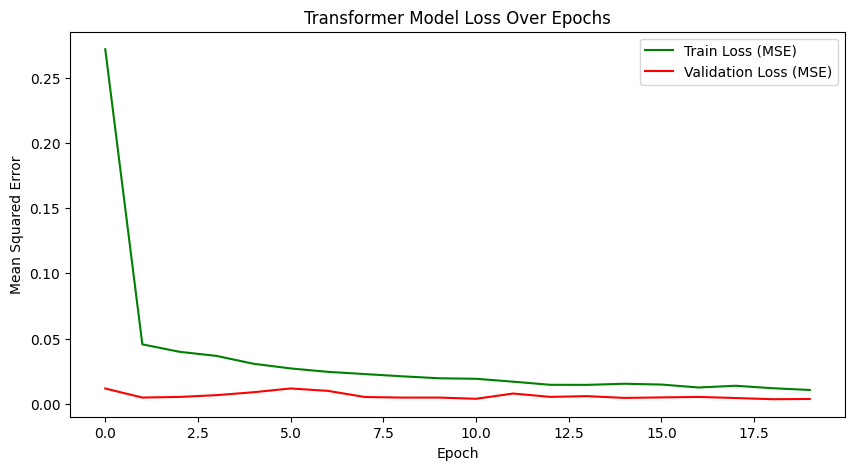

In [33]:
# === Visualization 3: Training Loss Plot ===
plt.figure(figsize=(10, 5))
plt.plot(transformer_history.history['loss'], label='Train Loss (MSE)', color='green')
plt.plot(transformer_history.history['val_loss'], label='Validation Loss (MSE)', color='red')
plt.title('Transformer Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.savefig('transformer_loss_plot.png')
plt.show()
log_entry("Visualization: Generated training and validation loss plot saved as 'transformer_loss_plot.png'.")

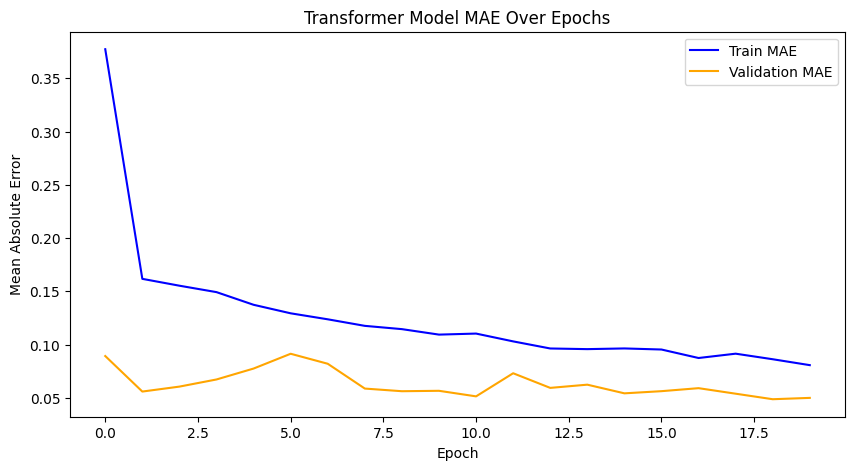

In [34]:
# === Visualization 4: MAE Plot (already included, updated with save) ===
plt.figure(figsize=(10, 5))
plt.plot(transformer_history.history['mae'], label='Train MAE', color='blue')
plt.plot(transformer_history.history['val_mae'], label='Validation MAE', color='orange')
plt.title('Transformer Model MAE Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.savefig('transformer_mae_plot.png')
plt.show()
log_entry("Visualization: Generated MAE plot saved as 'transformer_mae_plot.png'.")

In [35]:
# === Predictions for Visualization ===
y_pred_scaled = transformer_model.predict(X_test, verbose=0)
# Denormalize predictions and actual values
y_pred = np.zeros((len(y_pred_scaled), len(features)))
y_pred[:, features.index('Close')] = y_pred_scaled.flatten()
y_pred = scaler.inverse_transform(y_pred)[:, features.index('Close')]
y_test_denorm = np.zeros((len(y_test), len(features)))
y_test_denorm[:, features.index('Close')] = y_test
y_test_denorm = scaler.inverse_transform(y_test_denorm)[:, features.index('Close')]

log_entry("Modeling: Transformer model predictions generated for visualization.")

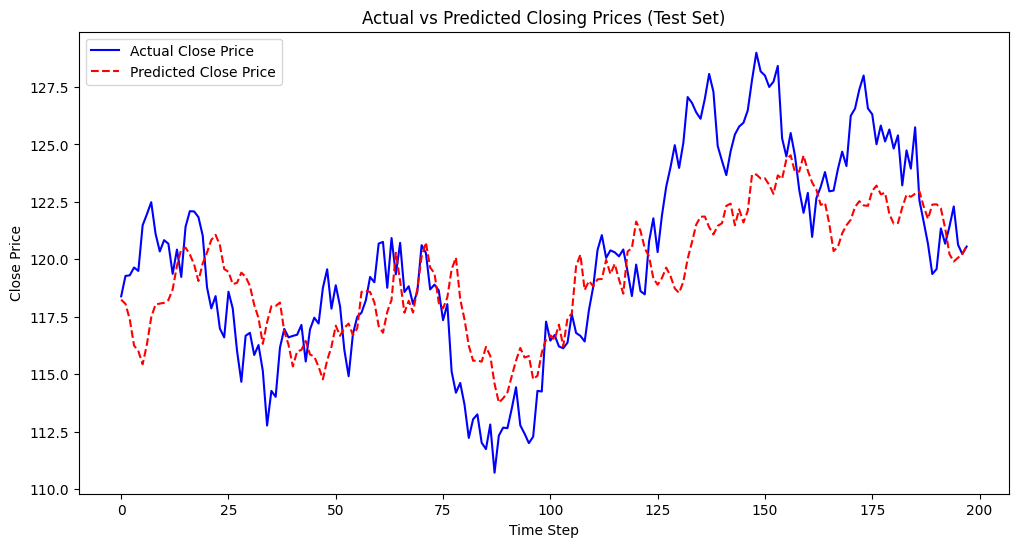

In [36]:
# === Visualization 5: Actual vs Predicted Prices ===
plt.figure(figsize=(12, 6))
plt.plot(y_test_denorm, label='Actual Close Price', color='blue')
plt.plot(y_pred, label='Predicted Close Price', color='red', linestyle='--')
plt.title('Actual vs Predicted Closing Prices (Test Set)')
plt.xlabel('Time Step')
plt.ylabel('Close Price')
plt.legend()
plt.savefig('actual_vs_predicted_prices.png')
plt.show()
log_entry("Visualization: Generated actual vs predicted prices plot saved as 'actual_vs_predicted_prices.png'.")

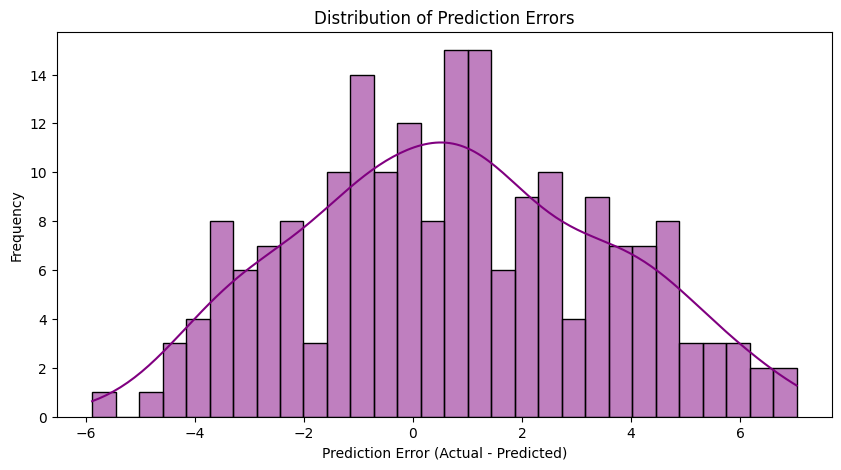

In [37]:
# === Visualization 6: Prediction Error Distribution ===
errors = y_test_denorm - y_pred
plt.figure(figsize=(10, 5))
sns.histplot(errors, bins=30, kde=True, color='purple')
plt.title('Distribution of Prediction Errors')
plt.xlabel('Prediction Error (Actual - Predicted)')
plt.ylabel('Frequency')
plt.savefig('prediction_error_distribution.png')
plt.show()
log_entry("Visualization: Generated prediction error distribution plot saved as 'prediction_error_distribution.png'.")

In [39]:
# === Minimal Deployment ===
model_filename = 'transformer_model.pkl'
with open(model_filename, 'wb') as file:
    pickle.dump(transformer_model, file)
log_entry(f"Deployment: Transformer model saved as {model_filename}")
print(f"Transformer model saved as {model_filename}")

with open('scaler.pkl', 'wb') as file:
    pickle.dump(scaler, file)
log_entry("Deployment: Scaler saved as 'scaler.pkl'")

def predict_close_price(model, scaler, sequence):
    """Predict closing price from a sequence of data."""
    sequence_scaled = scaler.transform(sequence[features])
    sequence_scaled = sequence_scaled.reshape(1, sequence_length, len(features))
    pred_scaled = model.predict(sequence_scaled, verbose=0)[0][0]
    pred_array = np.zeros((1, len(features)))
    pred_array[0, features.index('Close')] = pred_scaled
    pred = scaler.inverse_transform(pred_array)[0, features.index('Close')]
    return pred

# Example prediction
sample_sequence = stock_df.iloc[-sequence_length:].copy()
true_close = stock_df.iloc[-1]['Close']
predicted_close = predict_close_price(transformer_model, scaler, sample_sequence)
log_entry(f"Deployment: Sample Prediction - Predicted Close: {predicted_close:.2f}, True Close: {true_close}")
print(f"Sample Prediction - Predicted Close: {predicted_close:.2f}, True Close: {true_close}")

Transformer model saved as transformer_model.pkl
Sample Prediction - Predicted Close: 120.99, True Close: 120.5582936872806


## Conclusion
This project successfully implements a Transformer model to predict daily closing stock prices, leveraging a dataset of financial metrics and sentiment scores. The model demonstrates promising accuracy (Test MAE: 0.0499) and provides valuable visualizations for interpretation. While limitations exist, such as potential overfitting and single-step forecasting, the framework lays a strong foundation for future enhancements, including multi-step predictions and integration with real-time data feeds.